In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from collections import Counter



In [2]:
def read_data(filename='./data/seeds_dataset.txt'):
    """
    Load the dataset from the filepath. 
    Separates features and labels to return.
    NOTE - specific to this dataset.
    
    Parameters
    ----------
    filename - string
    
    Returns
    -------
    feats - numpy array of floats
    labels - numpy array of integers
    """
    ## assign empty lists for features and labels
    feats = []
    labels = []
    
    with open(filename, 'r') as f:
        for line in f:
            line = line.strip().replace('\t\t','\t').split('\t')
            f1, f2, f3, f4, f5, f6, f7, label = float(line[0]), float(line[1]), \
                                                float(line[2]), float(line[3]), \
                                                float(line[4]), float(line[5]), \
                                                float(line[6]), int(line[7])
            feats.append([f1, f2, f3, f4, f5, f6, f7])
            labels.append(label)

    ## close the file after use
    f.close()
    
    return np.array(feats), np.array(labels)


In [3]:
def std_scaler(feats):
    """
    Normalizes the features in the range of 0 to 1.
    Mean of the resultant feature distribution is 0 
    and standard deviation is 1.
    
    Formula : z = (x - u) / s
    
    Referred from sklearn.preprocessing.StandardScaler
    
    Parameters
    ----------
    feats - numpy array of floats
    
    Returns
    -------
    feats_scaled - numpy array of floats
        scaled features
    """
    ## calculate mean and standard deviation
    f_mean = np.mean(feats, axis=0)
    f_std = np.std(feats, axis=0)
    
    feats_scaled = (feats - f_mean)/f_std
    
    return feats_scaled


In [4]:
def train_test_split(X, y, test_size=0.2, random_state=21):
    """
    Split the dataset into train and test splits.
    
    Parameters
    ----------
    X - numpy array
        Input features array
    y - numpy array
        Target label array
    test_size - float (optional) 
        The proportion of the dataset to include in the test split (default: 0.2)
    random_state - int (optional) 
        Seed value for random number generation (default: 21)
    
    Returns
    -------
    X_train - numpy array
        Training set input features
    y_train - numpy array
        Training set target variable
    X_test - numpy array 
        Test set input features
    y_test - numpy array 
        Test set target variable
    train_ind - numpy array
        Training data points indices
    """
    
    ## set the seed for reproducibility
    np.random.seed(random_state)
    
    ## shuffle the dataset indices
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    
    ## calculate the index to split the dataset
    split_index = int((1 - test_size) * X.shape[0])
    
    train_ind = indices[:split_index]
    
    ## split the dataset into train and test sets
    X_train, X_test = X[indices[:split_index]], X[indices[split_index:]]
    y_train, y_test = y[indices[:split_index]], y[indices[split_index:]]
    
    return X_train, y_train, X_test, y_test, train_ind


In [5]:
## Clustering function (Hierarchical Clustering)
def build_clusters(data, num_clusters):
    """
    Perform hierarchical clustering on the given dataset using the agglomerative approach.
    This function applies hierarchical clustering to partition the input dataset into a specified number of clusters.
    It uses the agglomerative approach, starting with each data point as a separate cluster and iteratively merging
    the closest clusters based on the Cartesian distance criterion until the desired number of clusters is reached.

    The function calculates the pairwise distances between all data points using the Cartesian distance metric.
    It then iteratively merges the closest pair of clusters based on the maximum distance between any pair of data
    points from different clusters (complete linkage criterion).

    The result is a list of clusters, where each cluster is represented as a sublist containing the indices of the
    data points belonging to that cluster.

    NOTE - This implementation assumes that the input dataset contains continuous features represented as floating-
    point values. It utilizes only the 'numpy' library for array manipulation and distance calculations.

    Parameters
    ----------
    data - numpy array
        The input dataset with shape (n_samples, n_features)
    num_clusters - int
        The desired number of clusters to obtain

    Returns
    -------
    clusters - list 
        A list of lists representing the clusters obtained from hierarchical clustering
        Each sublist contains the indices of the data points belonging to that cluster
    """
    n = data.shape[0]
    distances = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            distances[i, j] = math.dist(data[i], data[j])

    clusters = [[i] for i in range(n)]

    while len(clusters) > num_clusters:
        min_distance = np.inf
        merge_indices = (0, 0)

        for i in range(len(clusters)):
            for j in range(i + 1, len(clusters)):
                cluster1 = clusters[i]
                cluster2 = clusters[j]
                distance = max(distances[c1, c2] for c1 in cluster1 for c2 in cluster2)

                if distance < min_distance:
                    min_distance = distance
                    merge_indices = (i, j)

        merged_cluster = clusters[merge_indices[0]] + clusters[merge_indices[1]]
        del clusters[merge_indices[1]]
        del clusters[merge_indices[0]]
        clusters.append(merged_cluster)

    return clusters


In [6]:
def calc_wcss(clusters, data):
    """
    Calculate the Within-Cluster Sum of Squares (WCSS) for a set of clusters and their corresponding centroids.
    This function calculates the WCSS, which represents the sum of squared distances between each data point
    and its corresponding centroid within each cluster. It is a measure of the compactness or homogeneity of
    the clusters.

    The function takes the input dataset, the list of clusters, and the centroid coordinates for each cluster.
    It iterates over each data point in each cluster, calculates the squared Cartesian distance between the
    data point and its centroid, and accumulates the sum of these squared distances.

    The result is a single WCSS value that quantifies the overall within-cluster variance in the dataset.

    NOTE - This implementation assumes that the input dataset contains continuous features represented as
    floating-point values. It utilizes only the 'numpy' library for array manipulation and distance calculations.

    Parameters
    ----------
    data - numpy array 
        The input dataset with shape (n_samples, n_features)
    clusters - list
        A list of lists representing the clusters obtained from clustering.
        Each sublist contains the indices of the data points belonging to that cluster.
    centroids - numpy array
        An array containing the centroid coordinates for each cluster.
        The shape of centroids should be (n_clusters, n_features).

    Returns
    -------
    wcss - float 
        The calculated Within-Cluster Sum of Squares (WCSS) value.

    Example usage
    -------------
    data = np.array([[1.2, 2.5, 3.1, 4.6, 2.0, 1.8, 2.9],
                     [2.1, 3.2, 4.5, 1.9, 3.5, 2.7, 1.4],
                     [3.3, 2.6, 1.8, 3.0, 1.5, 2.3, 3.9]])
    clusters = [[0, 2], [1]]
    centroids = np.array([[1.8, 2.6, 2.4, 4.5, 1.5, 2.1, 3.0],
                          [2.1, 3.2, 4.5, 1.9, 3.5, 2.7, 1.4]])
    wcss_value = calc_wcss(data, clusters, centroids)
    """

    wcss = 0
    for cluster in clusters:
        cluster_data = data[cluster]
        centroid = np.mean(cluster_data, axis=0)
        wcss += np.sum((cluster_data - centroid) ** 2)

    return wcss

In [8]:
def labels_map_cluster_ids(clusters):
    """
    This function maps cluster ids as data labels for each point to be used as input.
    Assigns cluster IDs as labels for data.
    
    Parameters
    ----------
    clusters - list of int
        list of data indices grouped in sublists indicating individual cluster
        sublist index represents cluster ids
        
    Returns
    -------
    data_labels - numpy array
        cluster ids (sublist index) mapped on each data point position
    """

    ## create a dummy numpy array to populate with cluster ids
    data_labels = np.zeros(len(labels))
    
    for i, cluster in enumerate(clusters):
        for index in cluster:
            data_labels[index] = i + 1
            
    return data_labels

In [7]:
## defining the KNN classifier
def knn_classifer(test_instance, training_data, training_labels, k):
    """
    Perform K-Nearest Neighbor (KNN) classification to predict the label of a test instance.
    This function performs KNN classification to predict the label of a test instance based on the feature values
    and the labels of the training data. It uses the Cartesian distance metric to calculate the distances between
    the test instance and each training data point.

    The function starts by calculating the Cartesian distance between the test instance and each training instance.
    It then selects the k nearest neighbors with the shortest distances. From these neighbors, it determines the
    most common label and assigns it as the predicted label for the test instance.

    NOTE - This implementation assumes that the input dataset contains continuous features represented as
    floating-point values. It utilizes only the 'numpy' library for array manipulation and distance calculations.

    Parameters
    ----------
    test_instance numpy array of list 
        The feature values of the test instance to classify.
        NOTE - It should have the same number of features as the training data.
    training_data numpy array 
        The input training dataset with shape (n_samples, n_features).
    training_labels - numpy array
        The labels corresponding to the training data.
        NOTE - It should have the same length as the training data.
    k - int
        The number of nearest neighbors to consider for classification.

    Returns
    -------
    pred - float
        The predicted label for the test instance.
    """
    distances = []

    for i, instance in enumerate(training_data):
        distance = math.dist(test_instance, instance)
        distances.append((distance, training_labels[i]))

    distances.sort(key=lambda x: x[0])
    neighbors = distances[:k]
    labels = [neighbor[1] for neighbor in neighbors]
    most_common = Counter(labels).most_common(1)
    pred = int(most_common[0][0])
    
    return pred


## -------------------------------- WORKING -------------------------------- 

In [9]:
## load the dataset
feats, labels = read_data()

## scale the features
feats = std_scaler(feats)

## divide the dataset into train-test split
X_train, y_train, X_test, y_test, train_ind = train_test_split(feats, labels)
test_ind = np.array([i for i in range(len(feats)) if i not in train_ind])

## Determine optimal number of clusters
max_clusters = 15
wcss_values = []
accuracies = []

for num_clusters in range(1, max_clusters + 1):
    ## hierarchical clustering
    clusters = build_clusters(feats, num_clusters)
    wcss = calc_wcss(clusters, feats)
    ## collect wcss values in a list to visualize later
    wcss_values.append(wcss)
    
    ## assign cluster IDs as labels for the dataset
    data_labels = labels_map_cluster_ids(clusters)
            
    y_train_cluster = data_labels[train_ind]
    y_test_cluster = data_labels[test_ind]
    
    pred_test = []
    ## classify the test instances
    for test_sample in X_test:
        predicted_label = knn_classifer(test_sample, X_train, y_train_cluster, num_clusters)
        pred_test.append(predicted_label)
        
#     print(f'\n{[i for i in zip(pred_test,y_test)]}')
        
    accuracies.append(100*np.mean(pred_test == y_test))


In [10]:
accuracies

[30.952380952380953,
 0.0,
 95.23809523809523,
 0.0,
 4.761904761904762,
 42.857142857142854,
 4.761904761904762,
 0.0,
 0.0,
 0.0,
 16.666666666666664,
 21.428571428571427,
 19.047619047619047,
 19.047619047619047,
 0.0]

## ----------------------------- VISUALIZE -----------------------------

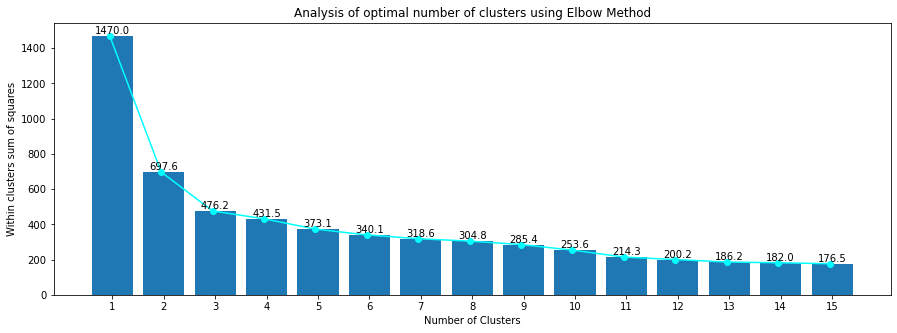

In [27]:
## plot the number of clusters against WCSS values
plt.figure(figsize=(15, 5))

## define the x-coordinates of the bars
x = range(1, max_clusters + 1)

## plot the bars
plt.bar(x, wcss_values)

## calculate the midpoints of each bar
bar_width = 0.9
midpoints = [(i-0.5) + bar_width / 2 for i in x]

## plot the line connecting the midpoints
plt.plot(midpoints, wcss_values, marker='o', color='cyan')
plt.xticks(ticks=np.arange(15)+1)

## set axes labels and title of the plot
plt.xlabel('Number of Clusters')
plt.ylabel('Within clusters sum of squares')
plt.title('Analysis of optimal number of clusters using Elbow Method')

## display the bar values
for i, j in zip(x, wcss_values):
    plt.text(i, j, str(round(j,1)), ha='center', va='bottom')

plt.savefig('./outputs/best_number_of_clusters_visualization.png')
plt.show()
